In [1]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import zipfile
import os, glob, random
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import yaml
import pandas as pd
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import seaborn as sns
from PIL import Image
from collections import Counter

sns.set_style("whitegrid")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
MODEL_320_PATH = "/content/best320.pt"
MODEL_640_PATH = "/content/best640.pt"

DATASET_ZIP = Path("/content/BCCD_VAL.zip")
DATASET_OUT = Path("/content")

In [4]:
# Extrair dataset
with zipfile.ZipFile(DATASET_ZIP, "r") as z:
    z.extractall(DATASET_OUT)

## 2. Validação dos Dois Modelos

In [6]:
model_320 = YOLO(MODEL_320_PATH)
results_320 = model_320.val(
    data=str("/content/BCCD_VAL/bccd_val_only.yaml"),
    imgsz=320,
    batch=16,
    verbose=False,
    name='val_320'
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11m summary (fused): 126 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 480.9±293.9 MB/s, size: 21.0 KB)
val: Scanning /content/BCCD_VAL/labels/val... 364 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 364/364 2.0Kit/s 0.2s
val: New cache created: /content/BCCD_VAL/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 3.9it/s 5.8s
                   all        364       4888      0.781      0.938      0.878       0.61
Speed: 0.4ms preprocess, 5.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/runs/detect/val_3202


In [8]:
model_640 = YOLO(MODEL_640_PATH)
results_640 = model_640.val(
    data=str("/content/BCCD_VAL/bccd_val_only.yaml"),
    imgsz=640,
    batch=16,
    verbose=False,
    name='val_640'
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11m summary (fused): 126 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1094.0±344.5 MB/s, size: 19.4 KB)
val: Scanning /content/BCCD_VAL/labels/val.cache... 364 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 364/364 138.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 23/23 2.1it/s 10.9s
                   all        364       4888      0.805      0.915      0.877      0.608
Speed: 2.0ms preprocess, 20.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val_6402


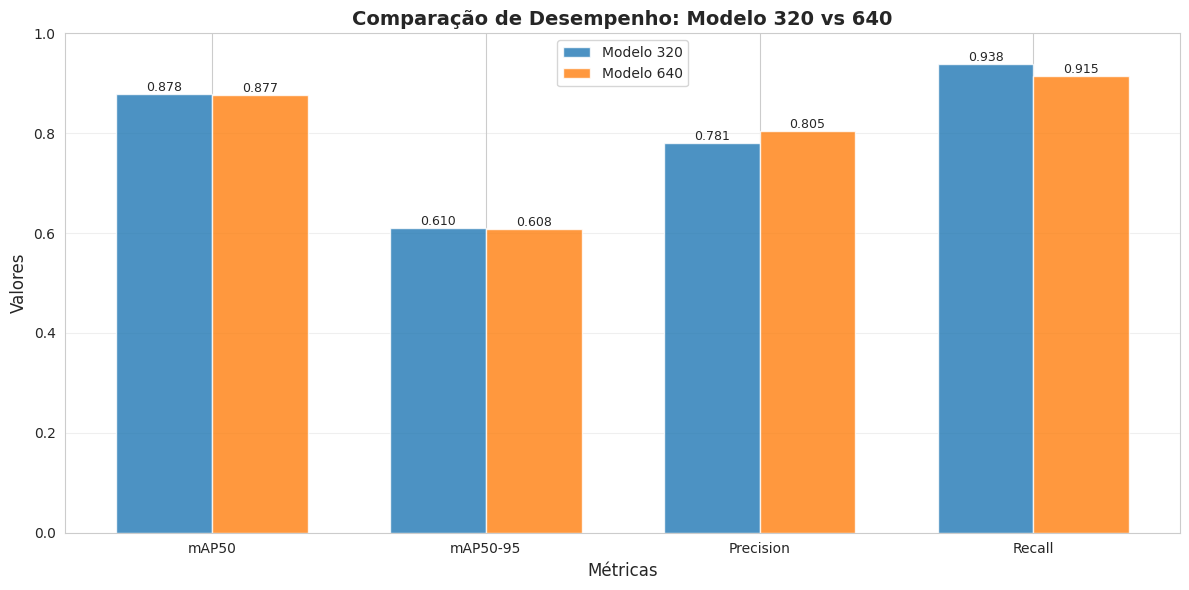

Gráfico salvo em: /content/metrics_comparison.png


In [10]:
metrics_320 = [results_320.box.map50, results_320.box.map, results_320.box.mp, results_320.box.mr]
metrics_640 = [results_640.box.map50, results_640.box.map, results_640.box.mp, results_640.box.mr]
metric_names = ['mAP50', 'mAP50-95', 'Precision', 'Recall']

x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, metrics_320, width, label='Modelo 320', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_640, width, label='Modelo 640', alpha=0.8)

ax.set_xlabel('Métricas', fontsize=12)
ax.set_ylabel('Valores', fontsize=12)
ax.set_title('Comparação de Desempenho: Modelo 320 vs 640', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/content/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico salvo em: /content/metrics_comparison.png")

## 4. Análise de Erros: Onde cada modelo errou?

In [11]:
def analyze_predictions(model, img_path, label_path, conf_threshold=0.25):
    """Analisa predições vs ground truth"""

    results = model.predict(img_path, conf=conf_threshold, verbose=False)
    pred_boxes = results[0].boxes


    with open(label_path, 'r') as f:
        gt_lines = f.readlines()


    img = Image.open(img_path)
    img_w, img_h = img.size

    gt_boxes = []
    for line in gt_lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cls, x_c, y_c, w, h = map(float, parts)
            gt_boxes.append({
                'class': int(cls),
                'bbox': [x_c, y_c, w, h]
            })


    pred_data = []
    if len(pred_boxes) > 0:
        for box in pred_boxes:
            xyxy = box.xyxy[0].cpu().numpy()
            x_c = ((xyxy[0] + xyxy[2]) / 2) / img_w
            y_c = ((xyxy[1] + xyxy[3]) / 2) / img_h
            w = (xyxy[2] - xyxy[0]) / img_w
            h = (xyxy[3] - xyxy[1]) / img_h

            pred_data.append({
                'class': int(box.cls[0].cpu().numpy()),
                'conf': float(box.conf[0].cpu().numpy()),
                'bbox': [x_c, y_c, w, h]
            })

    return gt_boxes, pred_data

def calculate_iou(box1, box2):
    """Calcula IoU entre duas boxes (formato: [x_center, y_center, width, height])"""
    box1_x1 = box1[0] - box1[2]/2
    box1_y1 = box1[1] - box1[3]/2
    box1_x2 = box1[0] + box1[2]/2
    box1_y2 = box1[1] + box1[3]/2

    box2_x1 = box2[0] - box2[2]/2
    box2_y1 = box2[1] - box2[3]/2
    box2_x2 = box2[0] + box2[2]/2
    box2_y2 = box2[1] + box2[3]/2
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    if x2 < x1 or y2 < y1:
        return 0.0

    intersection = (x2 - x1) * (y2 - y1)

    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0.0

In [16]:
yolo_root=Path("/content/BCCD_VAL")
val_images = list((yolo_root / 'images' / 'val').glob('*.jpg'))
class_names = ['WBC', 'RBC', 'Platelets']

errors_320 = {'FN': {c: [] for c in class_names}, 'FP': {c: [] for c in class_names}}
errors_640 = {'FN': {c: [] for c in class_names}, 'FP': {c: [] for c in class_names}}


only_320_correct = []  
only_640_correct = []  

iou_threshold = 0.5

print("🔍 Analisando predições...")
print("="*70)

for img_path in val_images:
    label_path = yolo_root / 'labels' / 'val' / f"{img_path.stem}.txt"

    if not label_path.exists():
        continue
    gt_boxes, pred_320 = analyze_predictions(model_320, str(img_path), str(label_path))
    _, pred_640 = analyze_predictions(model_640, str(img_path), str(label_path))
    for gt_box in gt_boxes:
        gt_class = class_names[gt_box['class']]
        matched_320 = False
        for pred in pred_320:
            if pred['class'] == gt_box['class']:
                iou = calculate_iou(gt_box['bbox'], pred['bbox'])
                if iou >= iou_threshold:
                    matched_320 = True
                    break

        matched_640 = False
        for pred in pred_640:
            if pred['class'] == gt_box['class']:
                iou = calculate_iou(gt_box['bbox'], pred['bbox'])
                if iou >= iou_threshold:
                    matched_640 = True
                    break
        if not matched_320:
            errors_320['FN'][gt_class].append(str(img_path))
        if not matched_640:
            errors_640['FN'][gt_class].append(str(img_path))
        if matched_320 and not matched_640:
            only_320_correct.append({
                'image': str(img_path),
                'class': gt_class,
                'type': 'FN_640'
            })
        elif matched_640 and not matched_320:
            only_640_correct.append({
                'image': str(img_path),
                'class': gt_class,
                'type': 'FN_320'
            })

    for pred in pred_320:
        pred_class = class_names[pred['class']]
        matched = False
        for gt_box in gt_boxes:
            if gt_box['class'] == pred['class']:
                iou = calculate_iou(pred['bbox'], gt_box['bbox'])
                if iou >= iou_threshold:
                    matched = True
                    break
        if not matched:
            errors_320['FP'][pred_class].append(str(img_path))

    for pred in pred_640:
        pred_class = class_names[pred['class']]
        matched = False
        for gt_box in gt_boxes:
            if gt_box['class'] == pred['class']:
                iou = calculate_iou(pred['bbox'], gt_box['bbox'])
                if iou >= iou_threshold:
                    matched = True
                    break
        if not matched:
            errors_640['FP'][pred_class].append(str(img_path))

print(" Análise concluída!")

🔍 Analisando predições...
✅ Análise concluída!


## 5. Sumário de Erros por Classe

In [17]:
print("\n" + "="*70)
print("ANÁLISE DE ERROS POR CLASSE - MODELO 320")
print("="*70)

for class_name in class_names:
    fn_count = len(set(errors_320['FN'][class_name]))
    fp_count = len(set(errors_320['FP'][class_name]))
    total_errors = fn_count + fp_count

    print(f"\n{class_name}:")
    print(f"  - False Negatives (não detectou): {fn_count}")
    print(f"  - False Positives (detectou errado): {fp_count}")
    print(f"  - Total de erros: {total_errors}")

print("\n" + "="*70)
print("ANÁLISE DE ERROS POR CLASSE - MODELO 640")
print("="*70)

for class_name in class_names:
    fn_count = len(set(errors_640['FN'][class_name]))
    fp_count = len(set(errors_640['FP'][class_name]))
    total_errors = fn_count + fp_count

    print(f"\n{class_name}:")
    print(f"  - False Negatives (não detectou): {fn_count}")
    print(f"  - False Positives (detectou errado): {fp_count}")
    print(f"  - Total de erros: {total_errors}")


ANÁLISE DE ERROS POR CLASSE - MODELO 320

WBC:
  - False Negatives (não detectou): 7
  - False Positives (detectou errado): 12
  - Total de erros: 19

RBC:
  - False Negatives (não detectou): 90
  - False Positives (detectou errado): 364
  - Total de erros: 454

Platelets:
  - False Negatives (não detectou): 19
  - False Positives (detectou errado): 113
  - Total de erros: 132

ANÁLISE DE ERROS POR CLASSE - MODELO 640

WBC:
  - False Negatives (não detectou): 4
  - False Positives (detectou errado): 12
  - Total de erros: 16

RBC:
  - False Negatives (não detectou): 79
  - False Positives (detectou errado): 364
  - Total de erros: 443

Platelets:
  - False Negatives (não detectou): 24
  - False Positives (detectou errado): 121
  - Total de erros: 145


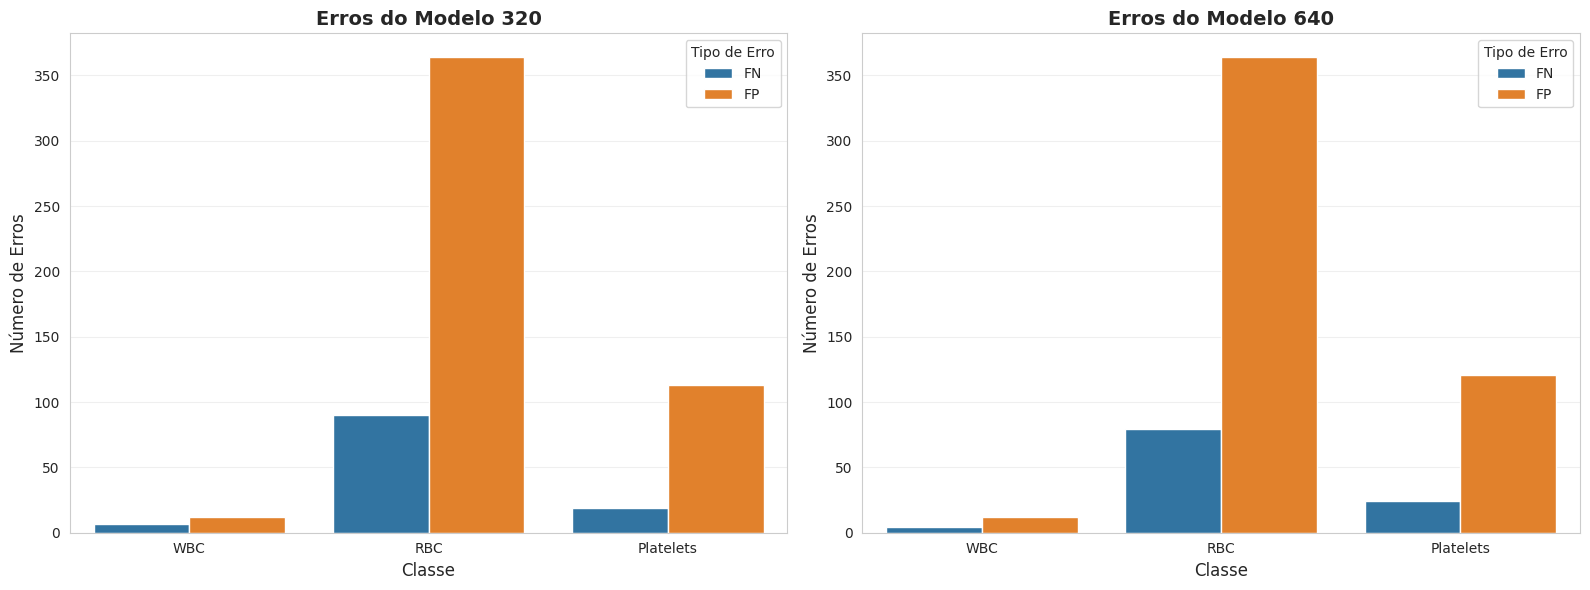

Gráfico de erros salvo em: /content/error_comparison.png


In [18]:
error_data_320 = []
error_data_640 = []

for class_name in class_names:
    fn_320 = len(set(errors_320['FN'][class_name]))
    fp_320 = len(set(errors_320['FP'][class_name]))
    fn_640 = len(set(errors_640['FN'][class_name]))
    fp_640 = len(set(errors_640['FP'][class_name]))

    error_data_320.append({'Class': class_name, 'Type': 'FN', 'Count': fn_320})
    error_data_320.append({'Class': class_name, 'Type': 'FP', 'Count': fp_320})
    error_data_640.append({'Class': class_name, 'Type': 'FN', 'Count': fn_640})
    error_data_640.append({'Class': class_name, 'Type': 'FP', 'Count': fp_640})

df_errors_320 = pd.DataFrame(error_data_320)
df_errors_640 = pd.DataFrame(error_data_640)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


sns.barplot(data=df_errors_320, x='Class', y='Count', hue='Type', ax=axes[0])
axes[0].set_title('Erros do Modelo 320', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Número de Erros', fontsize=12)
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].legend(title='Tipo de Erro')
axes[0].grid(axis='y', alpha=0.3)

sns.barplot(data=df_errors_640, x='Class', y='Count', hue='Type', ax=axes[1])
axes[1].set_title('Erros do Modelo 640', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Número de Erros', fontsize=12)
axes[1].set_xlabel('Classe', fontsize=12)
axes[1].legend(title='Tipo de Erro')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico de erros salvo em: /content/error_comparison.png")

## 6. Casos Interessantes: Onde um modelo acertou e outro errou

In [20]:
print("\n" + "="*70)
print("CASOS ONDE APENAS UM MODELO ACERTOU")
print("="*70)

print(f"\n Casos onde APENAS o Modelo 320 acertou: {len(only_320_correct)}")
if len(only_320_correct) > 0:
    df_320_only = pd.DataFrame(only_320_correct)
    print("\nDistribuição por classe:")
    print(df_320_only['class'].value_counts())

print(f"\n Casos onde APENAS o Modelo 640 acertou: {len(only_640_correct)}")
if len(only_640_correct) > 0:
    df_640_only = pd.DataFrame(only_640_correct)
    print("\nDistribuição por classe:")
    print(df_640_only['class'].value_counts())

print("\n" + "="*70)


CASOS ONDE APENAS UM MODELO ACERTOU

✅ Casos onde APENAS o Modelo 320 acertou: 47

Distribuição por classe:
class
RBC          39
Platelets     8
Name: count, dtype: int64

✅ Casos onde APENAS o Modelo 640 acertou: 73

Distribuição por classe:
class
RBC          66
Platelets     4
WBC           3
Name: count, dtype: int64



📸 Casos onde APENAS Modelo 320 acertou:


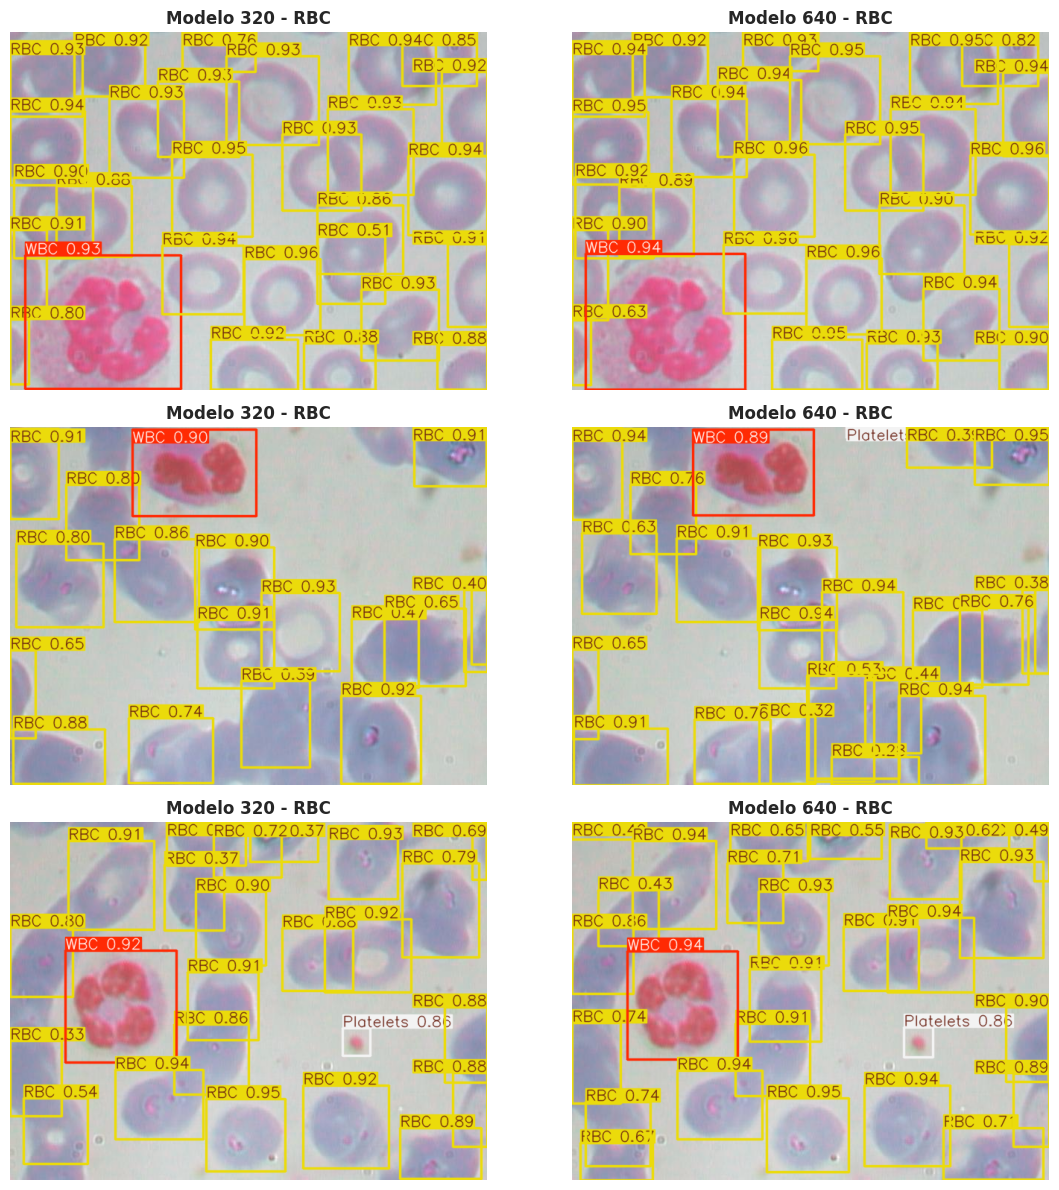

✅ Salvo em: /content/only_320_correct.png

📸 Casos onde APENAS Modelo 640 acertou:


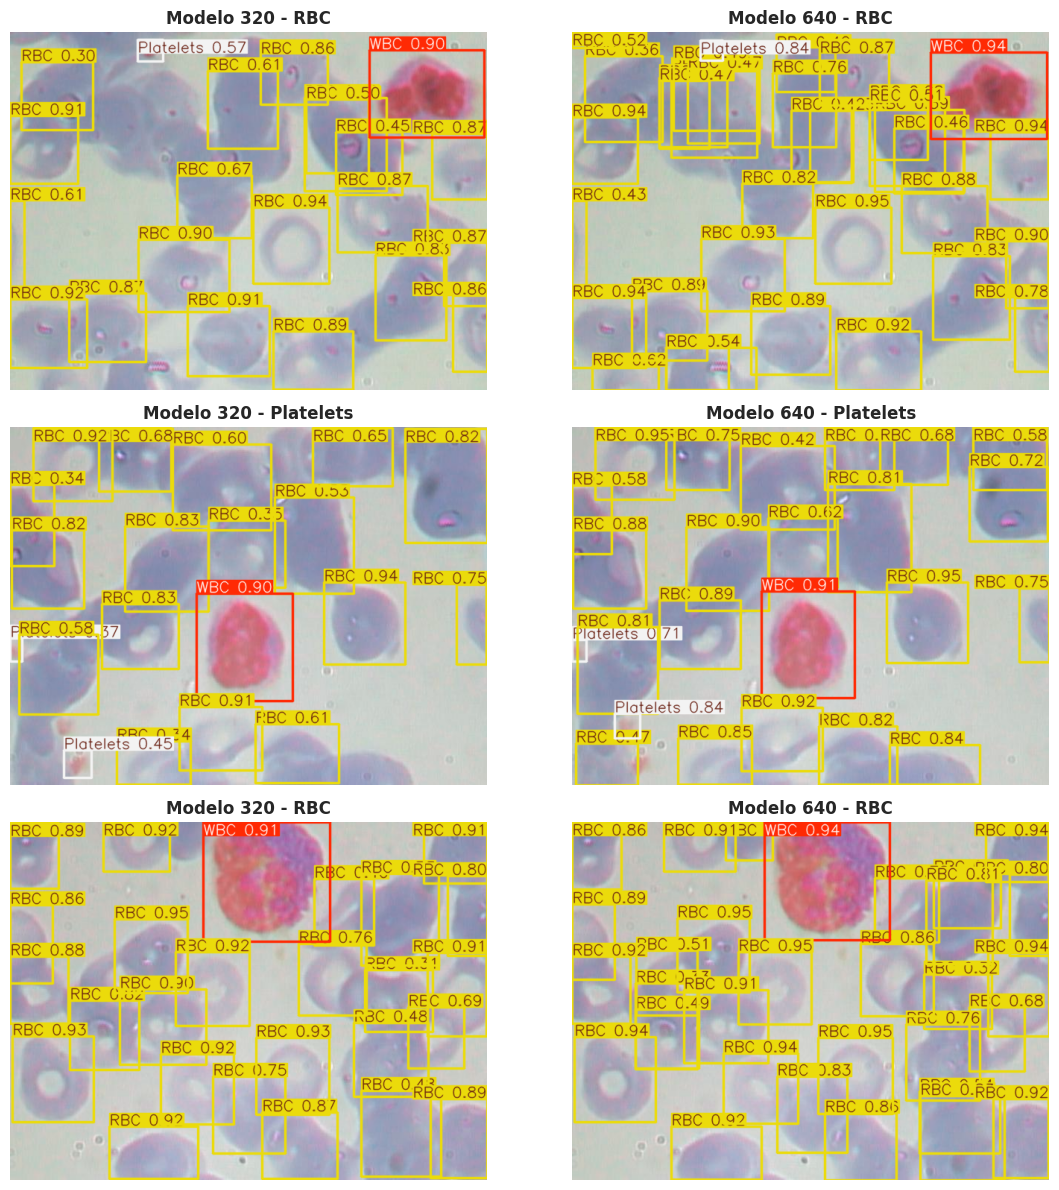

✅ Salvo em: /content/only_640_correct.png



In [21]:

def visualize_comparison_cases(cases, model_320, model_640, n_samples=6):
    """Visualiza casos onde um modelo acertou e outro errou"""
    if len(cases) == 0:
        print("Sem casos para visualizar.")
        return

    samples = random.sample(cases, min(n_samples, len(cases)))

    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, case in enumerate(samples):
        img_path = case['image']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        results_320 = model_320.predict(img_path, conf=0.25, verbose=False)
        img_320 = results_320[0].plot()

        results_640 = model_640.predict(img_path, conf=0.25, verbose=False)
        img_640 = results_640[0].plot()


        axes[idx, 0].imshow(img_320)
        axes[idx, 0].set_title(f"Modelo 320 - {case['class']}", fontweight='bold')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(img_640)
        axes[idx, 1].set_title(f"Modelo 640 - {case['class']}", fontweight='bold')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    return fig


if len(only_320_correct) > 0:
    print("📸 Casos onde APENAS Modelo 320 acertou:")
    fig1 = visualize_comparison_cases(only_320_correct, model_320, model_640, n_samples=3)
    if fig1:
        fig1.savefig('/content/only_320_correct.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Salvo em: /content/only_320_correct.png\n")


if len(only_640_correct) > 0:
    print("📸 Casos onde APENAS Modelo 640 acertou:")
    fig2 = visualize_comparison_cases(only_640_correct, model_320, model_640, n_samples=3)
    if fig2:
        fig2.savefig('/content/only_640_correct.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Salvo em: /content/only_640_correct.png\n")

## 7. Conclusões e Exportação de Resultados

In [22]:

report = f"""
{'='*70}
RELATÓRIO COMPARATIVO: MODELO 320 vs MODELO 640
{'='*70}

MÉTRICAS GERAIS:
----------------
Modelo 320:
  - mAP50: {results_320.box.map50:.4f}
  - mAP50-95: {results_320.box.map:.4f}
  - Precision: {results_320.box.mp:.4f}
  - Recall: {results_320.box.mr:.4f}

Modelo 640:
  - mAP50: {results_640.box.map50:.4f}
  - mAP50-95: {results_640.box.map:.4f}
  - Precision: {results_640.box.mp:.4f}
  - Recall: {results_640.box.mr:.4f}

DIFERENÇAS:
  - Δ mAP50: {((results_640.box.map50 - results_320.box.map50) / results_320.box.map50 * 100):+.2f}%
  - Δ mAP50-95: {((results_640.box.map - results_320.box.map) / results_320.box.map * 100):+.2f}%

ANÁLISE DE ERROS:
----------------
"""

for class_name in class_names:
    fn_320 = len(set(errors_320['FN'][class_name]))
    fp_320 = len(set(errors_320['FP'][class_name]))
    fn_640 = len(set(errors_640['FN'][class_name]))
    fp_640 = len(set(errors_640['FP'][class_name]))

    report += f"""
{class_name}:
  Modelo 320 - FN: {fn_320}, FP: {fp_320}
  Modelo 640 - FN: {fn_640}, FP: {fp_640}
"""

report += f"""

CASOS DIVERGENTES:
-----------------
  - Apenas 320 acertou: {len(only_320_correct)} casos
  - Apenas 640 acertou: {len(only_640_correct)} casos

{'='*70}
"""

print(report)

# Salvar relatório
with open('/content/comparison_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Relatório salvo em: /content/comparison_report.txt")


RELATÓRIO COMPARATIVO: MODELO 320 vs MODELO 640

MÉTRICAS GERAIS:
----------------
Modelo 320:
  - mAP50: 0.8783
  - mAP50-95: 0.6099
  - Precision: 0.7807
  - Recall: 0.9384

Modelo 640:
  - mAP50: 0.8768
  - mAP50-95: 0.6077
  - Precision: 0.8049
  - Recall: 0.9151

DIFERENÇAS:
  - Δ mAP50: -0.17%
  - Δ mAP50-95: -0.37%

ANÁLISE DE ERROS:
----------------

WBC:
  Modelo 320 - FN: 7, FP: 12
  Modelo 640 - FN: 4, FP: 12

RBC:
  Modelo 320 - FN: 90, FP: 364
  Modelo 640 - FN: 79, FP: 364

Platelets:
  Modelo 320 - FN: 19, FP: 113
  Modelo 640 - FN: 24, FP: 121


CASOS DIVERGENTES:
-----------------
  - Apenas 320 acertou: 47 casos
  - Apenas 640 acertou: 73 casos



✅ Relatório salvo em: /content/comparison_report.txt
